<a href="https://colab.research.google.com/github/AkshayaBrianTauro/ComputerVision/blob/master/src/Train_Model_ISIC_2017_Dataset_Exp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Team Members:
###Emeline Fratacci,
###Akshaya Brian Tauro,
###Course Number : CS 512, Semester : Spring 2023



**DATA:**
ISIC Challenge Data 2017 : https://challenge.isic-archive.com/data/#2017

Input Data - Original Image: https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip

Ground Truth Data - Masked: https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip



### Hyperparameters opted for tuning:
#### Epoch = 60 with patience 10. Trained Epoch Count - 60/60
#### Batch Size = 64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download the datasets

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
!unzip  ISIC-2017_Training_Data.zip

!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip
!unzip  ISIC-2017_Training_Part1_GroundTruth.zip

Streaming output truncated to the last 5000 lines.
  inflating: ISIC-2017_Training_Data/ISIC_0003056_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0003174.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0003174_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0003308.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0003308_superpixels.png  
 extracting: ISIC-2017_Training_Data/ISIC_0003346.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0003346_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0003728.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0003728_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0004110.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0004110_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0004115.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0004115_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0004166.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0004166_superpixels.png  
  inflating: 

In [ ]:
input_isic_path = "/content/ISIC-2017_Training_Data"
target_isic_path = "/content/ISIC-2017_Training_Part1_GroundTruth"






**Prepare the data**

In [ ]:
import os

#get image paths and sort by name
input_isic_paths = sorted(
    [os.path.join(input_isic_path, fname)
    for fname in os.listdir(input_isic_path)
        if fname.endswith(".jpg")])

target_isic_paths = sorted(
    [os.path.join(target_isic_path, fname)
    for fname in os.listdir(target_isic_path)
    if fname.endswith(".png") and not fname.startswith(".") ])
# print((target_isic_paths))
print("Total - ISIC Input Samples : ", len(target_isic_paths))

Total - ISIC Input Samples :  2000


**Visualize the segmentation mask**

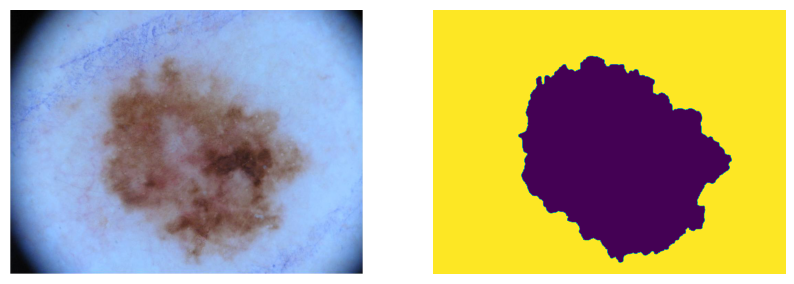

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

def display_target(target_array):
    normalized_array = (target_array.astype("uint8")-1)*127
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(load_img(input_isic_paths[2]))
    axs[0].axis('off')
    axs[1].imshow(normalized_array[:,:,0])
    axs[1].axis('off')
    plt.show()

img = img_to_array(load_img(target_isic_paths[2], color_mode = 'grayscale'))

display_target(img)

In [ ]:
import numpy as np
import random
img_size = (200,200) #resize images to 200 * 200
num_imgs = len(input_isic_paths) # total number of images

#use the same random seed to make sure images and segmentation maps match
random.Random(1337).shuffle(input_isic_paths)
random.Random(1337).shuffle(target_isic_paths)

#load image function
def path_to_input_image(path):
  return img_to_array(load_img(path, target_size = img_size))


#load segmentation map function
def path_to_target(path):
  img = img_to_array(load_img(path, target_size = img_size, color_mode = "grayscale"))
  # img = img.astype("uint8") #subtract 1 so for 0,1,2 image labels
  img[img == 0] = 0
  img[img == 255] = 1

  return img

#load all images
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype = "float32") # RGB
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8") # gray


for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_isic_paths[i])
    targets[i] = path_to_target(target_isic_paths[i])

print(len(input_imgs))
num_classes = len(np.unique(targets))
print("Number of unique classes:", num_classes)

2000
Number of unique classes: 2


**Train, Validation and test subsets**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation and test subsets
train_input_imgs, test_input_imgs, train_targets, test_targets = train_test_split(input_imgs, targets, test_size=0.2)
train_input_imgs, val_input_imgs, train_targets, val_targets = train_test_split(train_input_imgs, train_targets, test_size=0.2)

print('Number of training samples:', len(train_input_imgs))
print('Number of validation samples:', len(val_input_imgs))
print('Number of test samples:', len(test_input_imgs))

Number of training samples: 1280
Number of validation samples: 320
Number of test samples: 400


In [ ]:
num_classes = len(np.unique(targets))
print("Number of unique classes:", num_classes)

print(np.unique(targets))

Number of unique classes: 2
[0 1]


In [ ]:
import tensorflow as tf

# This is a bug fix for the Keras MeanIoU metric
# From https://stackoverflow.com/questions/61824470/dimensions-mismatch-error-when-using-tf-metrics-meaniou-with-sparsecategorical
class Mean_IoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(Mean_IoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)


metrics = [
   Mean_IoU(num_classes=num_classes), # bug fix for tf.keras.metrics.MeanIoU, see above
]

**Train a simple convolutional neural network for supervised semantic segmentation with skip connections as in Unet**.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.metrics import MeanIoU

def model_with_skip_connetions(img_size, num_classes):
   input_shape = Input(shape = img_size + (3, ))
   inputs = layers.Rescaling(1./255) (input_shape)

   #the contracting path
   conv1 = Conv2D(32,3, activation='relu', padding='same')(inputs)
   conv2 = Conv2D(32,3, activation='relu', padding='same')(conv1)
   pool1 = MaxPooling2D(pool_size=(2,2))(conv2)

   conv3 = Conv2D(64,3,activation='relu', padding='same')(pool1)
   conv4 = Conv2D(64,3,activation='relu', padding='same')(conv3)
   pool2 = MaxPooling2D(pool_size=(2,2))(conv4)

   conv5 = Conv2D(128,3,activation='relu',padding='same')(pool2)
   conv6 = Conv2D(128,3,activation='relu',padding='same')(conv5)
   drop1 = Dropout(0.5)(conv6)
   #bottle neck
   up1 = UpSampling2D(size=(2, 2))(drop1)
   concat1 = Concatenate()([conv4, up1])
   conv7 = Conv2D(64, 3, activation='relu',padding='same')(concat1)
   conv8 = Conv2D(64, 3, activation='relu',padding='same')(conv7)

   up2 = UpSampling2D(size=(2, 2))(conv8)
   concat2 = Concatenate()([conv2, up2])
   conv9 =  Conv2D(32,3, activation='relu', padding='same')(concat2)
   conv10 = Conv2D(32,3, activation='relu', padding='same')(conv9)

   outputs = Conv2D(num_classes, 1, activation='softmax')(conv10)

   model = Model(inputs=input_shape, outputs=outputs)

   model.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy", metrics=[Mean_IoU(num_classes=num_classes)])
  #  model.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy")
   return model

model = model_with_skip_connetions(img_size=img_size, num_classes=num_classes)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 200, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
#Early stop setup
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_input_imgs, train_targets,
                    epochs=60,
                    callbacks=early_stop,
                    batch_size=64,
                    validation_data = (val_input_imgs, val_targets))

model.save("/content/drive/MyDrive/CS 512 Computer Vision/CS512_final_course_project/data/models/Model-ISIC 2017 Dataset_Exp 1.h5")

Epoch 1/60
20/20 [==============================] - 40s 777ms/step - loss: 0.4879 - mean__io_u_1: 0.4091 - val_loss: 0.4121 - val_mean__io_u_1: 0.4000
Epoch 2/60
20/20 [==============================] - 15s 763ms/step - loss: 0.3932 - mean__io_u_1: 0.5314 - val_loss: 0.3946 - val_mean__io_u_1: 0.5507
Epoch 3/60
20/20 [==============================] - 15s 771ms/step - loss: 0.3729 - mean__io_u_1: 0.6020 - val_loss: 0.4037 - val_mean__io_u_1: 0.5478
Epoch 4/60
20/20 [==============================] - 16s 779ms/step - loss: 0.3673 - mean__io_u_1: 0.6103 - val_loss: 0.3714 - val_mean__io_u_1: 0.6087
Epoch 5/60
20/20 [==============================] - 16s 783ms/step - loss: 0.3524 - mean__io_u_1: 0.6278 - val_loss: 0.3688 - val_mean__io_u_1: 0.5971
Epoch 6/60
20/20 [==============================] - 16s 790ms/step - loss: 0.3514 - mean__io_u_1: 0.6240 - val_loss: 0.3638 - val_mean__io_u_1: 0.6034
Epoch 7/60
20/20 [==============================] - 16s 787ms/step - loss: 0.3492 - mean__io_u

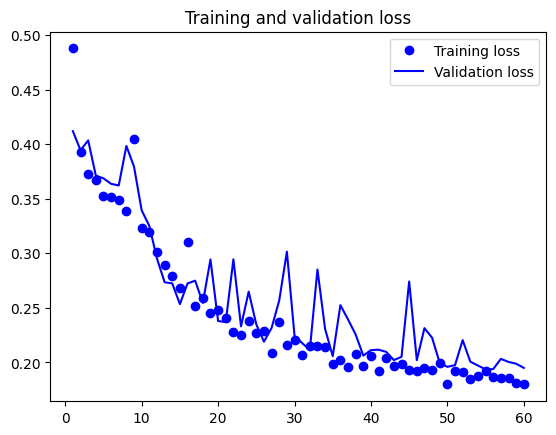

In [ ]:
#plot
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

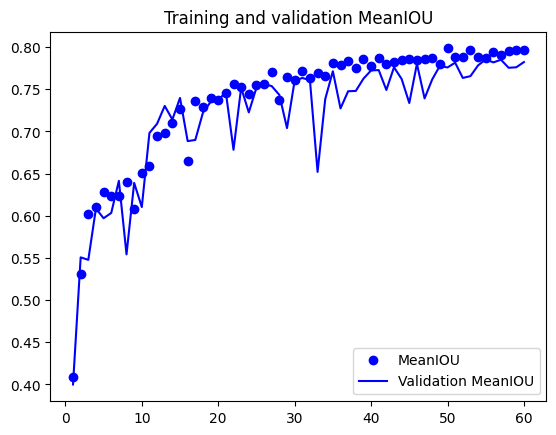

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["mean__io_u_1"]
val_loss = history.history["val_mean__io_u_1"]
plt.figure()
plt.plot(epochs, loss, "bo", label="MeanIOU")
plt.plot(epochs, val_loss, "b", label="Validation MeanIOU")
plt.title("Training and validation MeanIOU")
plt.legend()

**Inference results - validatation data**

1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     80000
           1       0.00      0.00      0.00         0

    accuracy                           0.81     80000
   macro avg       0.50      0.41      0.45     80000
weighted avg       1.00      0.81      0.90     80000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


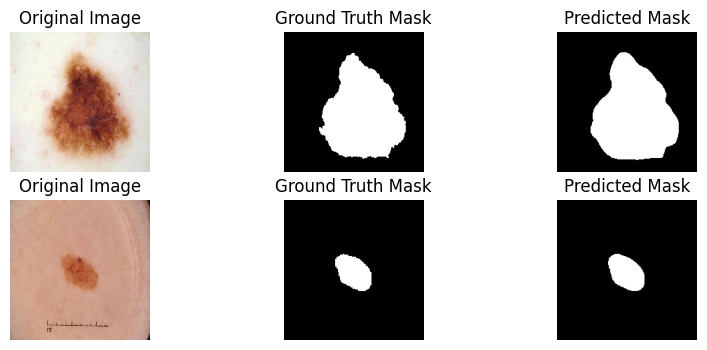

In [ ]:
import numpy as np
import random
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import array_to_img

# randomly select some test images
indices = random.sample(range(len(val_input_imgs)), 2)

# make predictions using the trained model
predicted_masks = model.predict(val_input_imgs[indices])

# get predicted class labels and true class labels
predicted_labels = predicted_masks.argmax(axis=-1).flatten()
true_labels = val_targets[indices].argmax(axis=-1).flatten()

# class_dict = {0: 'background', 1: 'foreground'}

# print classification report
print(classification_report(true_labels, predicted_labels))
# print(classification_report(true_labels, predicted_labels, target_names=class_dict.values()))

# display the original images, ground truth masks, and predicted masks
fig, axes = plt.subplots(len(indices), 3, figsize=(10, 4))

for i, index in enumerate(indices):
    # original image
    img = array_to_img(val_input_imgs[index])
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image')

    # ground truth mask
    axes[i, 1].imshow(val_targets[index].squeeze(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth Mask')

    # predicted mask
    axes[i, 2].imshow(predicted_masks[i].argmax(axis=-1), cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted Mask')

plt.show()


**Inference results - test data**

1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     80000
           1       0.00      0.00      0.00         0

    accuracy                           0.97     80000
   macro avg       0.50      0.49      0.49     80000
weighted avg       1.00      0.97      0.99     80000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


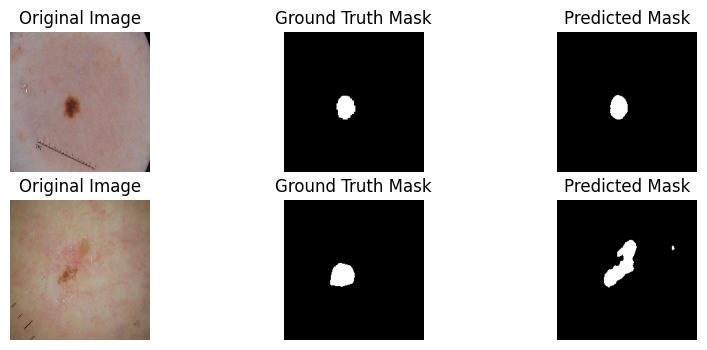

In [ ]:
import numpy as np
import random
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import array_to_img

# randomly select some test images
indices = random.sample(range(len(test_input_imgs)), 2)

# make predictions using the trained model
predicted_masks = model.predict(test_input_imgs[indices])

# get predicted class labels and true class labels
predicted_labels = predicted_masks.argmax(axis=-1).flatten()
true_labels = test_targets[indices].argmax(axis=-1).flatten()

# class_dict = {0: 'background', 1: 'foreground'}

# print classification report
print(classification_report(true_labels, predicted_labels))
# print(classification_report(true_labels, predicted_labels, target_names=class_dict.values()))

# display the original images, ground truth masks, and predicted masks
fig, axes = plt.subplots(len(indices), 3, figsize=(10, 4))

for i, index in enumerate(indices):
    # original image
    img = array_to_img(test_input_imgs[index])
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image')

    # ground truth mask
    axes[i, 1].imshow(test_targets[index].squeeze(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth Mask')

    # predicted mask
    axes[i, 2].imshow(predicted_masks[i].argmax(axis=-1), cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted Mask')

plt.show()
